In [14]:
import praw
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter
from nltk.corpus import stopwords
from IPython.display import display, HTML

In [15]:
# Download the VADER lexicon and stopwords
nltk.download('vader_lexicon')
nltk.download('stopwords')

# Reddit API credentialsimport praw
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter
from nltk.corpus import stopwords
from IPython.display import display, HTML
reddit = praw.Reddit(
    client_id='QtW5i86wx_goa7ojeKNWQQ',
    client_secret='-fl2QLqMuinZfdWDTt2JrUoFD8E7zg',
    user_agent='sentimental_analysis_project:v1.0.0 (by u/Realistic-Youth-4325)'
)

# Specify the post URL or ID
post_id = '1e8gtxv'  # Replace with your post ID

# Fetch the specific post
post = reddit.submission(id=post_id)

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Prepare data for analysis
data = []
post.comments.replace_more(limit=0)
for comment in post.comments.list():
    sentiment = sid.polarity_scores(comment.body)
    comment_time = datetime.fromtimestamp(comment.created_utc, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    data.append([comment.body, sentiment['compound'], comment_time])

# Convert data to DataFrame
df = pd.DataFrame(data, columns=['Comment', 'Sentiment', 'Time'])

# Save to CSV for further analysis
csv_path = 'reddit_post_sentiment_analysis.csv'
df.to_csv(csv_path, index=False)

# Provide link to download CSV file
download_link = f'<a href="{csv_path}" download>Click here to download the CSV file</a>'
display(HTML(download_link))





[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\SIRI\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SIRI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


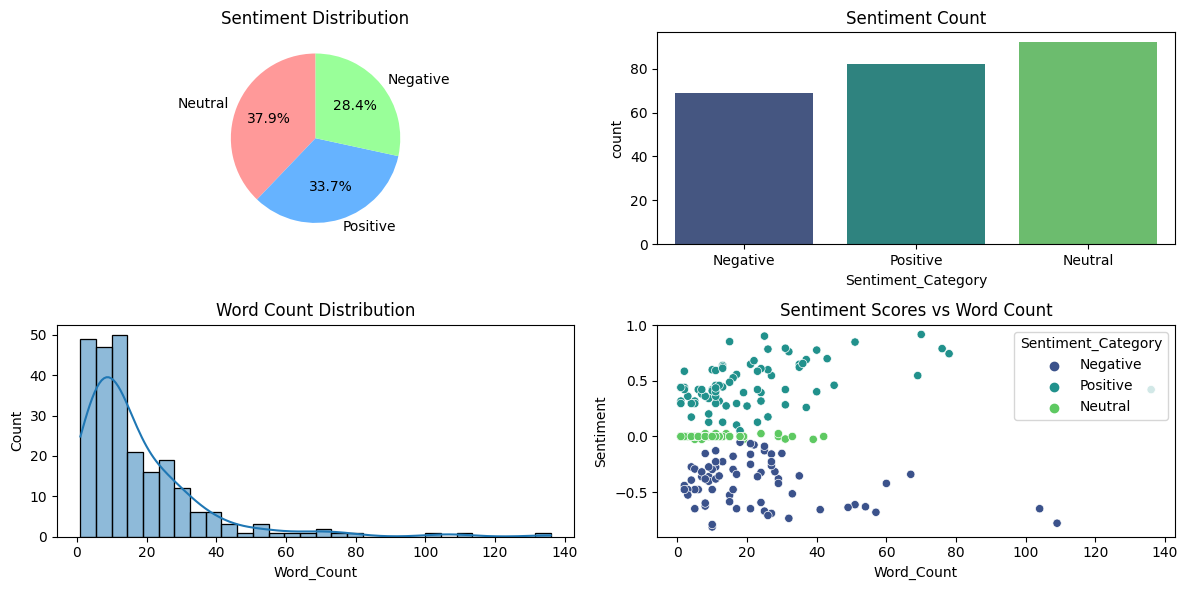

In [16]:
# Categorize sentiments
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment_Category'] = df['Sentiment'].apply(categorize_sentiment)

# Preprocess text
def preprocess_text(text):
    return text.lower()

df['Cleaned_Comment'] = df['Comment'].apply(preprocess_text)



# Feature: Display visualizations
def plot_visualizations(df):
    plt.figure(figsize=(12, 6))
    
    # Pie chart for sentiment distribution
    plt.subplot(2, 2, 1)
    df['Sentiment_Category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title('Sentiment Distribution')
    plt.ylabel('')
    
    # Bar chart for sentiment distribution
    plt.subplot(2, 2, 2)
    sns.countplot(x='Sentiment_Category', data=df, palette='viridis')
    plt.title('Sentiment Count')
    
    # Word count distribution
    df['Word_Count'] = df['Comment'].apply(lambda x: len(x.split()))
    plt.subplot(2, 2, 3)
    sns.histplot(df['Word_Count'], bins=30, kde=True)
    plt.title('Word Count Distribution')
    
    # Scatter plot for sentiment scores
    plt.subplot(2, 2, 4)
    sns.scatterplot(x='Word_Count', y='Sentiment', hue='Sentiment_Category', data=df, palette='viridis')
    plt.title('Sentiment Scores vs Word Count')
    
    plt.tight_layout()
    plt.show()

# Feature: Most frequently used emotion-expressing words
def most_frequent_words(df, top_n=10):
    emotion_words = ['wow', 'amazing', 'good', 'bad', 'terrible', 'awesome', 'horrible', 'great', 'poor', 'beautiful','ass']
    stop_words = set(stopwords.words('english'))
    
    all_words = ' '.join(df['Cleaned_Comment']).split()
    filtered_words = [word for word in all_words if word not in stop_words and word in emotion_words]
    
    word_freq = Counter(filtered_words)
    common_words = word_freq.most_common(top_n)
    return pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plot_visualizations(df)


In [17]:
# Preprocess text
def preprocess_text(text):
    return text.lower()

df['Cleaned_Comment'] = df['Comment'].apply(preprocess_text)

# Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(df['Cleaned_Comment'])

# Encode sentiment labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentiment_Category'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a machine learning model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



              precision    recall  f1-score   support

    Negative       0.60      0.27      0.37        11
     Neutral       0.48      0.67      0.56        21
    Positive       0.47      0.41      0.44        17

    accuracy                           0.49        49
   macro avg       0.52      0.45      0.46        49
weighted avg       0.50      0.49      0.48        49



In [18]:
# Final Analysis with the trained model
new_comments = [
    "I love this product! It's amazing.",
    
    "The movie was okay, not too bad but not great either.",
    "I absolutely hate this! It's terrible.",
    
]

# Preprocess new comments
new_comments_cleaned = [preprocess_text(comment) for comment in new_comments]
new_comments_tfidf = tfidf.transform(new_comments_cleaned)

# Predict sentiments
predicted_sentiments = model.predict(new_comments_tfidf)
predicted_labels = label_encoder.inverse_transform(predicted_sentiments)

# Display results
for comment, sentiment in zip(new_comments, predicted_labels):
    print(f"Comment: {comment}\nPredicted Sentiment: {sentiment}\n")


Comment: I love this product! It's amazing.
Predicted Sentiment: Positive

Comment: The movie was okay, not too bad but not great either.
Predicted Sentiment: Neutral

Comment: I absolutely hate this! It's terrible.
Predicted Sentiment: Negative



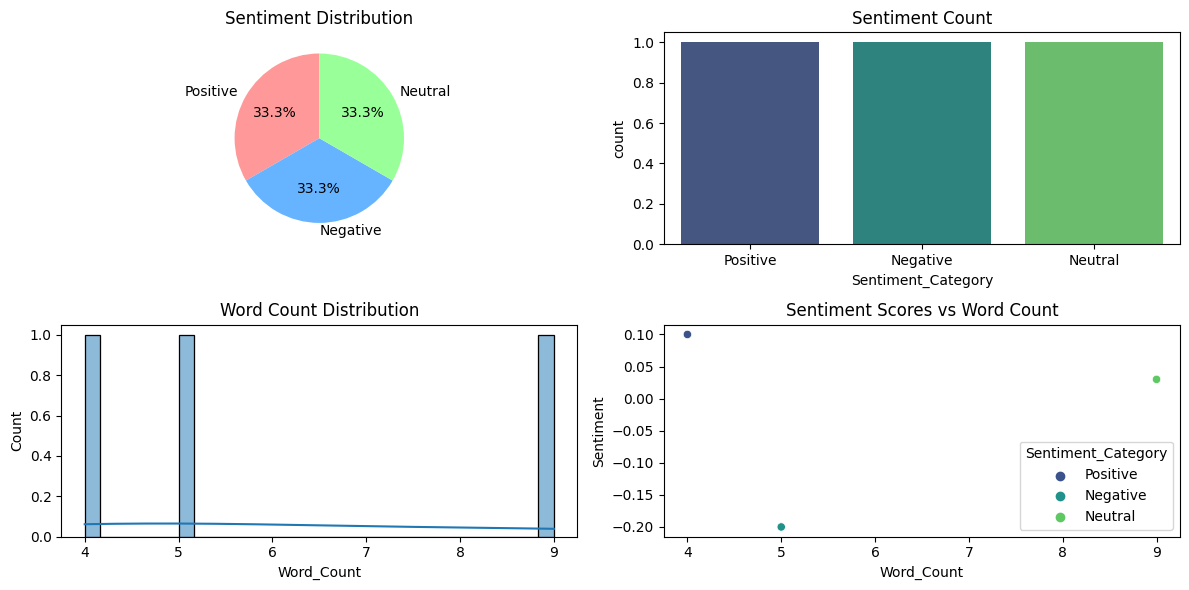

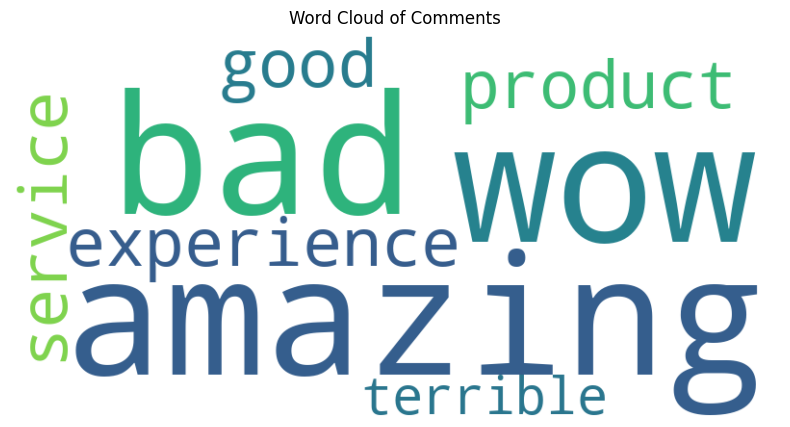

  Word  Frequency
0  bad          1


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter

# Sample DataFrame
df = pd.DataFrame({
    'Comment': ['Wow, this is amazing!', 'I had a bad experience.', 'The product is good, but the service is terrible.']
})

# Categorize sentiments
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = [0.1, -0.2, 0.03]  # Example sentiment scores
df['Sentiment_Category'] = df['Sentiment'].apply(categorize_sentiment)

# Preprocess text
def preprocess_text(text):
    return text.lower()

df['Cleaned_Comment'] = df['Comment'].apply(preprocess_text)

# Feature: Display visualizations
def plot_visualizations(df):
    plt.figure(figsize=(12, 6))
    
    # Pie chart for sentiment distribution
    plt.subplot(2, 2, 1)
    df['Sentiment_Category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
    plt.title('Sentiment Distribution')
    plt.ylabel('')
    
    # Bar chart for sentiment distribution
    plt.subplot(2, 2, 2)
    sns.countplot(x='Sentiment_Category', data=df, palette='viridis')
    plt.title('Sentiment Count')
    
    # Word count distribution
    df['Word_Count'] = df['Comment'].apply(lambda x: len(x.split()))
    plt.subplot(2, 2, 3)
    sns.histplot(df['Word_Count'], bins=30, kde=True)
    plt.title('Word Count Distribution')
    
    # Scatter plot for sentiment scores
    plt.subplot(2, 2, 4)
    sns.scatterplot(x='Word_Count', y='Sentiment', hue='Sentiment_Category', data=df, palette='viridis')
    plt.title('Sentiment Scores vs Word Count')
    
    plt.tight_layout()
    plt.show()

# Feature: Most frequently used emotion-expressing words
def most_frequent_words(df, top_n=10):
    emotion_words = ['wow', 'amazing', 'good', 'bad', 'terrible', 'awesome', 'horrible', 'great', 'poor', 'beautiful','ass']
    stop_words = set(stopwords.words('english'))
    
    all_words = ' '.join(df['Cleaned_Comment']).split()
    filtered_words = [word for word in all_words if word not in stop_words and word in emotion_words]
    
    word_freq = Counter(filtered_words)
    common_words = word_freq.most_common(top_n)
    return pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Feature: Display word cloud
def plot_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Comments')
    plt.show()

plot_visualizations(df)

# Combine all cleaned comments into a single text for word cloud
all_comments = ' '.join(df['Cleaned_Comment'])
plot_word_cloud(all_comments)

# Display most frequent emotion-expressing words
print(most_frequent_words(df))


In [2]:
import joblib


In [3]:

joblib.dump(model, 'sentiment_model.pkl')#conversion


NameError: name 'model' is not defined